# 为*CharityML*寻找捐献者

## 开始

项目中使用的是1994年美国人口普查收集的数据，选用几个监督学习算法以准确地建模被调查者的收入。然后，根据初步结果从中选择出最佳的候选算法，并进一步优化该算法以最好地建模这些数据。目标是建立一个能够准确地预测被调查者年收入是否超过50000美元的模型。这种类型的任务一般会出现在那些依赖于捐款而存在的非营利性组织（并且我认为特定商品的推送email也同样使用）。了解人群的收入情况可以帮助一个非营利性的机构更好地了解他们要多大的捐赠，或是否他们应该接触这些人。虽然我们很难直接从公开的资源中推断出一个人的一般收入阶层，但是我们可以（也正是我们将要做的）从其他的一些公开的可获得的资源中获得一些特征从而推断出该值。

这个项目的数据集来自[UCI机器学习知识库](https://archive.ics.uci.edu/ml/datasets/Census+Income)。  

----
## 探索数据
运行下面的代码单元以载入需要的Python库并导入人口普查数据。数据集的最后一列`'income'`是需要预测的列（表示被调查者的年收入会大于或者是最多50,000美元），人口普查数据中的每一列都将是关于被调查者的特征。

In [2]:
# 为这个项目导入需要的库
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # 允许为DataFrame使用display()

# 导入附加的可视化代码visuals.py
import visuals as vs

# 为notebook提供更加漂亮的可视化
%matplotlib inline

# 导入人口普查数据
data = pd.read_csv("census.csv")

# 成功 - 显示第一条记录
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### 练习：数据探索
首先对数据集进行一个粗略的探索，将看看每一个类别里会有多少被调查者，并且告诉我们这些里面多大比例是年收入大于50,000美元的。在下面的代码单元中，我将计算以下量：

- 总的记录数量，`'n_records'`
- 年收入大于50,000美元的人数，`'n_greater_50k'`.
- 年收入最多为50,000美元的人数 `'n_at_most_50k'`.
- 年收入大于50,000美元的人所占的比例， `'greater_percent'`.

In [3]:
# 总的记录数
from __future__ import division
n_records = len(data)

# 被调查者的收入大于$50,000的人数
n_greater_50k = len(data[data['income'] == '>50K'])

# 被调查者的收入最多为$50,000的人数
n_at_most_50k = len(data[data['income'] == '<=50K'])

# 被调查者收入大于$50,000所占的比例
greater_percent = n_greater_50k / n_records * 100

# 打印结果
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## 准备数据
在数据能够被作为输入提供给机器学习算法之前，它经常需要被清洗，格式化，和重新组织 - **预处理**。幸运的是，对于这个数据集，没有必须处理的无效或丢失的条目，然而，由于某一些特征存在的特性我们必须进行一定的调整。这个预处理都可以极大地帮助提升几乎所有的学习算法的结果和预测能力。

### 转换倾斜的连续特征

一个数据集有时可能包含至少一个靠近某个数字的特征，但有时也会有一些相对来说存在极大值或者极小值的不平凡分布的的特征。算法对这种分布的数据会十分敏感，并且如果这种数据没有能够很好地规一化处理会使得算法表现不佳。在人口普查数据集的两个特征符合这个描述：'`capital-gain'`和`'capital-loss'`。

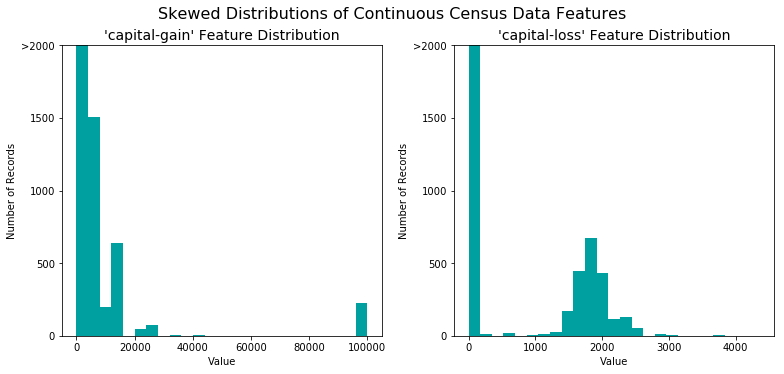

In [4]:
# 将数据切分成特征和对应的标签
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# 可视化原来数据的倾斜的连续特征
vs.distribution(data)

对于高度倾斜分布的特征如`'capital-gain'`和`'capital-loss'`，常见的做法是对数据施加一个<a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">对数转换</a>，将数据转换成对数，这样非常大和非常小的值不会对学习算法产生负面的影响。并且使用对数变换显著降低了由于异常值所造成的数据范围异常。但是在应用这个变换时必须小心：因为0的对数是没有定义的，所以我们必须先将数据处理成一个比0稍微大一点的数以成功完成对数转换。

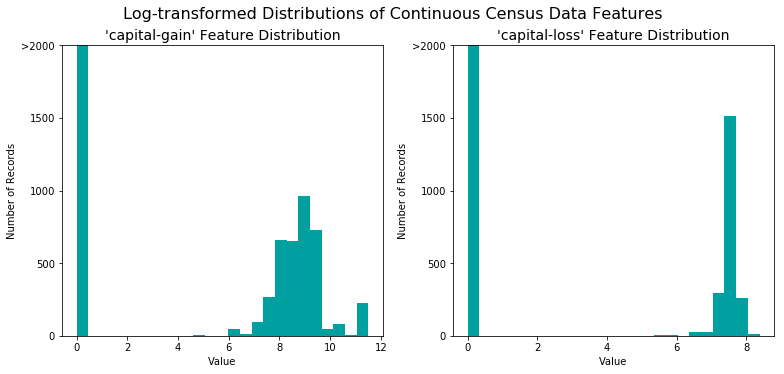

In [5]:
# 对于倾斜的数据使用Log转换
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# 可视化经过log之后的数据分布
vs.distribution(features_raw, transformed = True)

### 规一化数字特征
除了对于高度倾斜的特征施加转换，通常要对数值特征施加一些形式的缩放。在数据上面施加一个缩放并不会改变数据分布的形式（比如上面说的'capital-gain' or 'capital-loss'）；但是，规一化保证了每一个特征在使用监督学习器的时候能够被平等的对待。注意一旦使用了缩放，观察数据的原始形式不再具有它本来的意义了。

In [6]:
# 导入sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 初始化一个 scaler，并将它施加到特征上
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# 显示一个经过缩放的样例记录
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### 练习：数据预处理

从上面的**数据探索**中的表中，我们可以看到有几个属性的每一条记录都是非数字的。通常情况下，学习算法期望输入是数字的，这要求非数字的特征（称为类别变量）被转换。转换类别变量的一种流行的方法是使用**独热编码**方案。独热编码为每一个非数字特征的每一个可能的类别创建一个_“虚拟”_变量。例如，假设`someFeature`有三个可能的取值`A`，`B`或者`C`，。我们将把这个特征编码成`someFeature_A`, `someFeature_B`和`someFeature_C`.

|   | 一些特征 |                    | 特征_A | 特征_B | 特征_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> 独热编码 ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

此外，对于非数字的特征，我们需要将非数字的标签`'income'`转换成数值以保证学习算法能够正常工作。因为这个标签只有两种可能的类别（"<=50K"和">50K"），我们不必要使用独热编码，可以直接将他们编码分别成两个类`0`和`1`。

In [7]:
# 使用pandas.get_dummies()对'features_raw'数据进行独热编码
features = pd.get_dummies(features_raw)

# 将'income_raw'编码成数字值
income = income_raw.apply(lambda x:0 if x == '<=50K' else 1)

# 打印经过独热编码之后的特征数量
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# 移除下面一行的注释以观察编码的特征名字

103 total features after one-hot encoding.


### 混洗和切分数据
现在所有的 _类别变量_ 已被转换成数值特征，而且所有的数值特征已被规一化。和我们一般情况下做的一样，我们现在将数据（包括特征和它们的标签）切分成训练和测试集。其中80%的数据将用于训练和20%的数据用于测试。

In [8]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split

# 将'features'和'income'数据切分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# 显示切分的结果
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## 评价模型性能
在这一部分中，将尝试四种不同的算法，并确定哪一个能够最好地建模数据。

### 评价方法
*CharityML*通过他们的研究人员知道被调查者的年收入大于\$50,000最有可能向他们捐款。因为这个原因*CharityML*对于准确预测谁能够获得\$50,000以上收入尤其有兴趣。这样看起来使用**准确率**作为评价模型的标准是合适的。另外，把*没有*收入大于\$50,000的人识别成年收入大于\$50,000对于*CharityML*来说是有害的，因为他想要找到的是有意愿捐款的用户。这样，我们期望的模型具有准确预测那些能够年收入大于\$50,000的能力比模型去**查全**这些被调查者*更重要*。我们能够使用**F-beta score**作为评价指标，这样能够同时考虑查准率和查全率：

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$


尤其是，当$\beta = 0.5$的时候更多的强调查准率，这叫做**F$_{0.5}$ score** （或者为了简单叫做F-score）。

### 朴素预测器
*如果我们选择一个无论什么情况都预测被调查者年收入大于\$50,000的模型，那么这个模型在这个数据集上的准确率和F-score是多少？*  

In [9]:
#计算准确率
true_positive = n_greater_50k
false_positive = n_at_most_50k
false_negetive = true_negetive = 0
precision = true_positive / (true_positive + false_positive)
recall = true_positive/ (true_positive + false_negetive)

accuracy = (true_positive + true_negetive)/ n_records

#使用上面的公式，并设置beta=0.5计算F-score
fscore = (1.0 + 0.5 ** 2) * (precision * recall) / ((0.5 ** 2 * precision)+ recall)
                                               
#打印结果                               
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### 监督学习模型
**下面的监督学习模型是现在在** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **中能够选择的模型**
- 高斯朴素贝叶斯 (GaussianNB)
- 决策树
- 集成方法 (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K近邻 (KNeighbors)
- 随机梯度下降分类器 (SGDC)
- 支撑向量机 (SVM)
- Logistic回归


**被选模型概述**  
* **决策树：[贷款申请审核](https://www.ibm.com/developerworks/cn/analytics/library/ba-1507-decisiontree-algorithm/index.html) 决策树共三层，共三个特性，是否有房产，是否结婚，月收入衡量。 决策树模型的优势是，首先非常好理解，而且易于搭建。在决策树模型中，特征的数据不需要归一化，就可以得到平等对待。在大规模的数据中，以上优点更为突出。而且决策树可以用于类别型数据，也可用于处理数值型数据。但是如果决策树的枝叶很多的话，则会导致过拟合，此时就需要剪枝处理。当前数据特点是类别型数据多，但是也有数值型数据，输出是类别型数据，所以用决策树是一个好方法。** 

* **集成（Boost）：[篮球运动员图像捕捉](https://www.uni-obuda.hu/journal/Markoski_Ivankovic_Ratgeber_Pecev_Glusac_57.pdf) 利用AdaBoost算法和采集到的篮球运动员在比赛过程中的图片（以及一些其他干扰图片作为负样本），训练模型来捕捉篮球比赛中的运动员图像，在测试时，借以替换不相关背景的手段来混淆一下，以更好地训练模型。 Boost通过弱学习器经过很多次针对输入数据的学习（判断、划重点），最终将结果整合到一起的学习模型，所以即使算法简单、单一结果一般，但整合之后也可以得到一个很好的结果。还一个特点就是基本不会过拟合，适用于二分类、多分类的情况。但如果用于Boost的弱分类器是含有多节点、多层次的神经网络，便会容易出现过拟合。 Boost属于多个分类器集成的一种算法，所以也适用于本类型的数据。** 

* **Logistic回归：[学生录取判断](https://stats.idre.ucla.edu/stata/dae/logistic-regression/) 可依据GPA、GRE、学校等级，来判断该学生是否会被录取。 此算法基于sigmoid函数，此函数的输出范围为0--1，模型根据其输出判断样本属于0还是1，因此非常适用于而分类的问题。但同时这也是其局限性。本问题的输出结果就是而分类，所以适用。**

### 创建一个训练和预测的流水线
为了正确评估选择的每一个模型的性能，需要创建一个能够快速有效地使用不同大小的训练集并在测试集上做预测的训练和测试的流水线。

In [10]:
#从sklearn中导入两个评价指标 - fbeta_score和accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # 使用sample_size大小的训练数据来拟合学习器
    start = time() # 获得程序开始时间
    learner = learner.fit(X_train[: sample_size], y_train[: sample_size])
    end = time() # 获得程序结束时间
    
    #计算训练时间
    results['train_time'] = end - start
    
    # 得到在测试集上的预测值
    # 然后得到对前300个训练数据的预测结果
    start = time() # 获得程序开始时间
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[: 300])
    end = time() # 获得程序结束时间
    
    # 计算预测用时
    results['pred_time'] = end - start
            
    # 计算在最前面的300个训练数据的准确率
    results['acc_train'] = accuracy_score(y_train[: 300], predictions_train)
        
    # TODO：计算在测试集上的准确率
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # 计算在最前面300个训练数据上的F-score
    results['f_train'] = fbeta_score(y_train[: 300], predictions_train, beta = 0.5)
        
    # 计算测试集上的F-score
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # 成功
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
    
    # 返回结果
    return results

### 初始模型的评估

DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


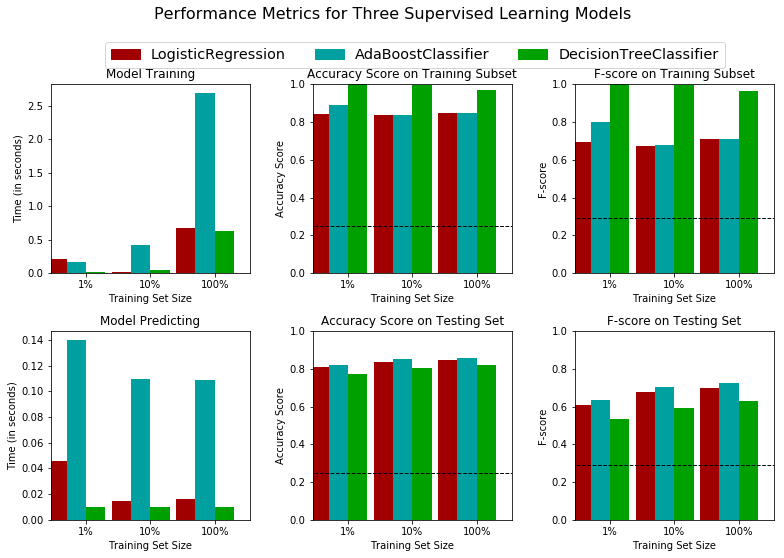

In [11]:
# 从sklearn中导入三个监督学习模型
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn import linear_model

# 初始化三个模型
clf_A = tree.DecisionTreeClassifier(random_state = 0)
clf_B = AdaBoostClassifier(random_state = 0)
clf_C = linear_model.LogisticRegression(random_state = 0)

# 计算1%， 10%， 100%的训练数据分别对应多少点
samples_1 = len(X_train) // 100
samples_10 = len(X_train) // 10
samples_100 = len(X_train)

# 收集学习器的结果
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# 对选择的三个模型得到的评价结果进行可视化
vs.evaluate(results, accuracy, fscore)

----
## 提高效果

在整个训练集（`X_train`和`y_train`）上通过使用网格搜索优化至少调节一个参数，以获得一个比没有调节之前更好的F-score。

### 选择最佳的模型  
从上面的图表中可以看出，Logistic回归的泛化能力很好，在这三个模型中，虽然比AdaBoost的准确率稍低，但是计算时间要很短很多，因此综合考虑，还是判断Logistic回归为最佳模型。  
Logistic回归其实是一种分类器，将给定样本的特征以及特征所占据的权重作为输入的数据传入到分类器中。这个分类器就是一个分类函数，这个函数以权重作为参数，把输入的样本特征进行计算转换，然后得到范围是0到1的数据，可以看作用来衡量特征所对应的样本是属于1，还是属于0（一般都以0.5为分界线）的概率。上面提到的参数，我们事先是不知道的。既然计算出的数据是属于某个标记的概率，那么我们可以认为，我们训练这个分类器的任务就是令每个样本属于其事先标记好的标记的概率越大越好。即，我们事先知道了结果，然后用这个结果逐步推导出我们想要的因素——逐步改变参数，进而改变函数输出的数据（即概率），来令这个概率越来越大，训练得到最优模型。  
这个函数最后的输出为0或1，非常符合本数据的输出，也就是说根据样本特征，判断出该样本属于0，还是属于1。所以我们可以采用Logistic回归。  
以这个数据为例来说，例如我们将某个人的年龄、学历、职位、婚姻等信息，专递给了我们实现已经训练好的模型，然后这个模型把这些信息数据经过各种计算，最后得出了一个数字，这个数字的范围是0到1，于是我们可以把这个数字看成一个概率。对于模型来说，如果超过0.5，那么就可以把这个人归为1类。如果小于0.5，就把这个人归为0类。我们规定，如果这个人最后算出来是0类，那么就代表他的年收入不超过5万，否则超过5万。于是，按照上面的步骤，我们就可以将所有人进行归类。

### 模型调优
调节选择的模型的参数。使用网格搜索（GridSearchCV）来调整模型的重要参数。

In [12]:
# 导入'GridSearchCV', 'make_scorer'和其他一些需要的库
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import make_scorer

# 初始化分类器
clf = clf_C
#clf = clf_B

# 创建希望调节的参数列表
parameters = {'penalty':['l1', 'l2'],'C':[0.01, 0.1, 1, 10, 100, 300, 600, 1000]}
#parameters = {'n_estimators' : range(50, 550, 50), 'learning_rate' :np.linspace(0.01, 0.2, 20) }


# 创建一个fbeta_score打分对象
scorer = make_scorer(fbeta_score, beta = 0.5)

#cv_set = KFold(n_splits=10, random_state=None, shuffle=False)

# 在分类器上使用网格搜索，使用'scorer'作为评价函数
grid_obj = GridSearchCV(clf, parameters, scorer, cv = 10)
#rdm_obj = RandomizedSearchCV(clf,parameters,scoring=scorer, n_iter = 6)

# 用训练数据拟合网格搜索对象并找到最佳参数
grid_obj = grid_obj.fit(X_train, y_train)
#rdm_obj.fit(X_train, y_train)

# 得到estimator
best_clf = grid_obj.best_estimator_
#best_clf = rdm_obj.best_estimator_

# 使用没有调优的模型做预测
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# 汇报调参前和调参后的分数
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
#print pd.DataFrame(rdm_obj.cv_results_)

Unoptimized model
------
Accuracy score on testing data: 0.8483
F-score on testing data: 0.6993

Optimized Model
------
Final accuracy score on the testing data: 0.8494
Final F-score on the testing data: 0.7008


## 提取特征重要性

选择一个`scikit-learn`中有`feature_importance_`属性的监督学习分类器，这个属性是一个在做预测的时候根据所选择的算法来对特征重要性进行排序的功能。

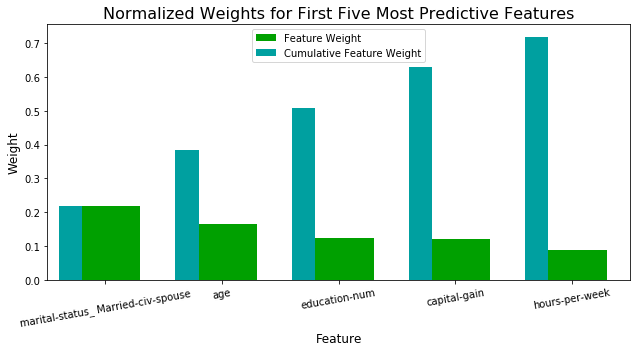

In [17]:
#导入一个有'feature_importances_'的监督学习模型（即模型A）

# 在训练集上训练一个监督学习模型
model = clf_A.fit(X_train, y_train)

# 提取特征重要性
importances = model.feature_importances_

# 绘图
vs.feature_plot(importances, X_train, y_train)

### 特征选择

如果我们只是用可用特征的一个子集的话模型表现会怎么样？通过使用更少的特征来训练，在评价指标的角度来看我们的期望是训练和预测的时间会更少。从上面的可视化来看，我们可以看到前五个最重要的特征贡献了数据中**所有**特征中超过一半的重要性。这提示我们可以尝试去*减小特征空间*，并简化模型需要学习的信息。

In [41]:
# 导入克隆模型的功能
from sklearn.base import clone
from sklearn.decomposition import PCA

# 减小特征空间
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

#降低维度与减小特征空间相结合
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train[X_train.columns.values[(np.argsort(importances)[::-1])[3:]]])
X_test_pca = pca.transform(X_test[X_test.columns.values[(np.argsort(importances)[::-1])[3:]]])

# 在前面的网格搜索的基础上训练一个“最好的”模型
start = time()
clf_reduced = (clone(best_clf)).fit(X_train_reduced, y_train)

# 做一个新的预测（reduced）
reduced_predictions = clf_reduced.predict(X_test_reduced)
end = time()
time_reduced = end - start

#做一个新的预测（PCA与reduced相结合）
start = time()
clf_pca = (clone(best_clf)).fit(X_train_pca, y_train)
pca_predictions = clf_pca.predict(X_test_pca)
end = time()
time_pca = end - start

#用full_data训练一个“最好的”模型
start = time()
clf = (clone(best_clf)).fit(X_train, y_train)
full_predictions = clf.predict(X_test)
end = time()
time_full = end - start

# 对于每一个版本的数据汇报最终模型的分数
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, full_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, full_predictions, beta = 0.5))
print "Time spent on testing data: {:.4f}".format(time_full)

print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))
print "Time spent on testing data: {:.4f}".format(time_reduced)

print "\nFinal Model trained on pca-reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, pca_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, pca_predictions, beta = 0.5))
print "Time spent on testing data: {:.4f}".format(time_pca)

Final Model trained on full data
------
Accuracy on testing data: 0.8494
F-score on testing data: 0.7008
Time spent on testing data: 1.2230

Final Model trained on reduced data
------
Accuracy on testing data: 0.8347
F-score on testing data: 0.6678
Time spent on testing data: 0.1380

Final Model trained on pca-reduced data
------
Accuracy on testing data: 0.7506
F-score on testing data: 0.4044
Time spent on testing data: 0.0370


### 特征选择的影响

相比来说，三个评分相差不是很大，但是就时间来看,reduced的时间占用要比full-data小得多，而pca与reduced的结合时间占用就更小了。所以说特征选择是非常高效的手段。结合训练时间与模型要求精度综合考虑的话，基本会舍弃一些重要性不大的特征，进行折衷。